# Bert on 40-10-50 split Cleaned

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# these libraries are used for the text cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#these libraries are building the model
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler

# seed for reproducibility
seed = 1111

c:\Developer\cs178-group-project\IMDB_ven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the dataframes
train_data = pd.read_csv("train_review_data.csv",usecols=["review", "label"])
test_data = pd.read_csv("test_review_data.csv", usecols=["review", "label"])
full_data = pd.read_csv("full_review_data.csv", usecols=["review", "label"])

In [3]:
def remove_emojis_and_special_chars(text):
    # Remove emojis using a regex pattern
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Removes non-ASCII characters (including emojis)
    
    # Remove any other non-alphanumeric characters (if needed)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Removes any character that is not a letter, number, or space
    
    return text


def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Normalize repeated punctuation
    text = re.sub(r'([!?])\1+', r'\1', text)
    
    # Fix spacing after punctuation
    text = re.sub(r'([.,!?])([^\s])', r'\1 \2', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading and trailing spaces
    text = text.strip()
    
    # Optionally, convert to lowercase (for bert-base-uncased model)
    text = text.lower()
    
    # Remove emojis and special characters
    text = remove_emojis_and_special_chars(text)
    
    return text

In [4]:
# Clean the text on both test and train data to see if BERT performs better on it
train_data['review'] = train_data['review'].apply(clean_text)
test_data['review'] = test_data['review'].apply(clean_text)

In [5]:
display(train_data)

,review,label
0,zentropa has much in common with the third man...,1
1,zentropa is the most original movie ive seen i...,1
2,lars von trier is never backward in trying out...,1
3,contains spoilers due to me having to describe...,1
4,that was the first thing that sprang to mind a...,1
...,...,...
24995,there just isnt enough here there a few funny ...,0
24996,tainted look at kibbutz lifethis film is less ...,0
24997,i saw this movie just now not when it was rele...,0
24998,any film which begins with a cowhand shagging ...,0


In [6]:
X_train = list(train_data['review'])
X_test = list(test_data['review'])
Y_train = list(train_data['label'])
Y_test = list(test_data['label'])

#splitting the train set into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=seed)

In [7]:
# Construct a BERT tokenizer, reutrns a list of input IDs with the appropriate special tokens.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing function
def tokenize_data(texts, tokenizer, max_len=512):
    return tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",  # Pads to max_len
        truncation=True,      # Truncates to max_len
        return_tensors="pt"   # Returns PyTorch tensors
    )

# Tokenize datasets
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

In [8]:
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = IMDBDataset(train_encodings, Y_train)
val_dataset = IMDBDataset(val_encodings, Y_val)
test_dataset = IMDBDataset(test_encodings, Y_test)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

# Added seed for reproducibility
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
epochs = 3

# reference: https://stackoverflow.com/questions/60120043/optimizer-and-scheduler-for-bert-fine-tuning
num_training_steps = len(train_loader) * epochs
scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

def train_epoch(model, dataloader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [11]:
def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []  # To store predictions
    all_labels = []  # To store ground truth labels

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Get model outputs
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # Get predicted class indices
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Return predictions and labels along with loss and accuracy
    return total_loss / len(dataloader), correct / total, all_preds, all_labels

In [12]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

all_test_preds = []
all_test_labels = []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
    val_loss, val_acc, val_preds, val_labels = evaluate_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

# Evaluate on the test set and retrieve predictions and labels
test_loss, test_acc, test_preds, test_labels = evaluate_epoch(model, test_loader, device)
print()
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Epoch 1/3
Train Loss: 0.2572 | Train Accuracy: 0.8938
Val Loss: 0.2015 | Val Accuracy: 0.9202
Epoch 2/3
Train Loss: 0.1032 | Train Accuracy: 0.9650
Val Loss: 0.2230 | Val Accuracy: 0.9254
Epoch 3/3
Train Loss: 0.0260 | Train Accuracy: 0.9928
Val Loss: 0.2597 | Val Accuracy: 0.9294

Test Loss: 0.2392 | Test Accuracy: 0.9360


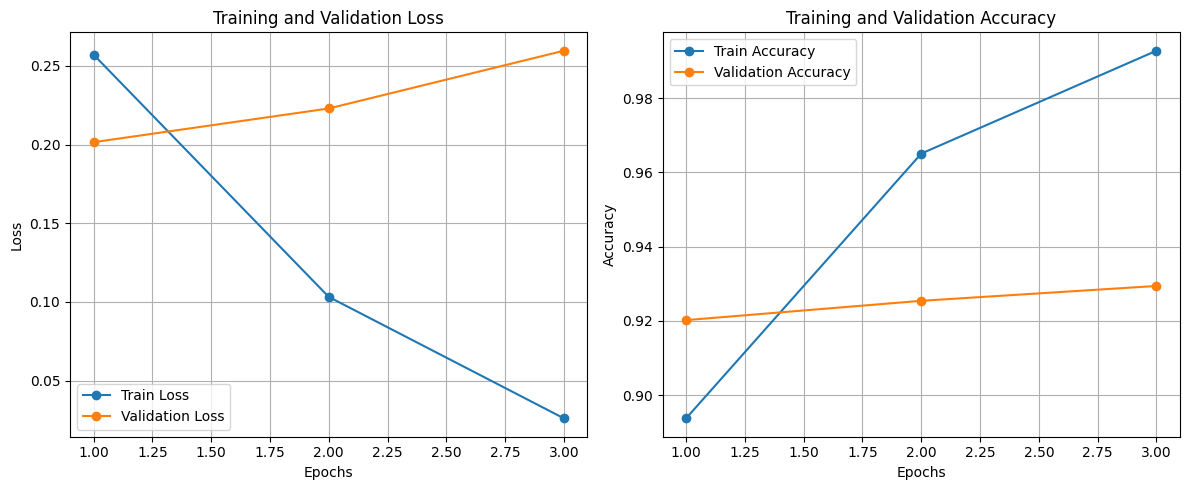

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

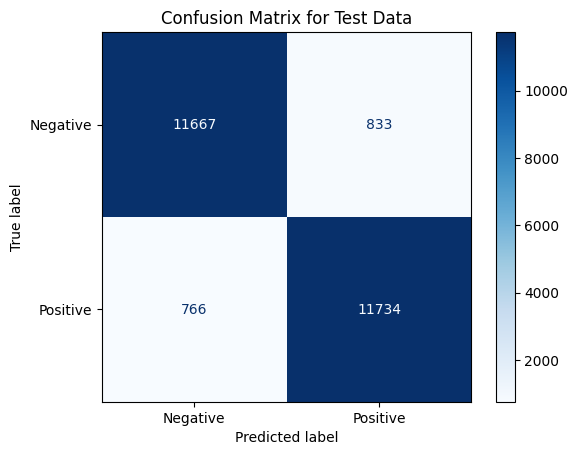

In [14]:
# Generate confusion matrix for the test set
cm = confusion_matrix(test_labels, test_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Test Data")
plt.show()